# 🔧 Linear Elasticity Interactive Demo

**Real-time FEA simulation powered by JAX JIT compilation**

- **Geometry**: 100×10×10 mm cantilever beam
- **Material**: Aluminum (E=70 GPa, ν=0.3)
- **Loading**: Traction applied on right face (z-direction)
- **Boundary**: Left face fixed (all DOFs)

Move the slider to see **instant** FEA results!

In [1]:
import feax as fe
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import numpy as onp
from ipywidgets import interact, FloatSlider

%matplotlib inline

## Setup FEA Problem

In [2]:
# Material properties
elastic_moduli = 70e3  # MPa
poisson_ratio = 0.3
tol = 1e-5

# Define mesh - coarse for instant response
L = 100
W = 10
H = 10
box_size = (L, W, H)
mesh = fe.mesh.box_mesh(box_size, mesh_size=3)

print(f"Mesh created: {mesh.points.shape[0]} nodes, {mesh.cells.shape[0]} elements")

Mesh created: 544 nodes, 297 elements


In [3]:
# Boundary locations
left = lambda point: np.isclose(point[0], 0., tol)
right = lambda point: np.isclose(point[0], L, tol)

# Define problem class
E = elastic_moduli
nu = poisson_ratio

class LinearElasticity(fe.problem.Problem):
    def get_tensor_map(self):
        def stress(u_grad, *args):
            mu = E / (2. * (1. + nu))
            lmbda = E * nu / ((1 + nu) * (1 - 2 * nu))
            epsilon = 0.5 * (u_grad + u_grad.T)
            return lmbda * np.trace(epsilon) * np.eye(self.dim) + 2 * mu * epsilon
        return stress

    def get_surface_maps(self):
        def surface_map(u, x, traction_mag):
            return np.array([0., 0., traction_mag])
        return [surface_map]

problem = LinearElasticity(mesh, vec=3, dim=3, location_fns=[right])
print("Problem defined")

Problem defined


In [4]:
# Boundary conditions
left_fix = fe.DCboundary.DirichletBCSpec(
    location=left,
    component="all",
    value=0.
)
bc_config = fe.DCboundary.DirichletBCConfig([left_fix])
bc = bc_config.create_bc(problem)

## Create JIT-Compiled Solver

In [5]:
# Create solver
solver_option = fe.solver.SolverOptions(linear_solver="bicgstab")
solver = fe.solver.create_solver(problem, bc, solver_option, iter_num=1)
initial = fe.utils.zero_like_initial_guess(problem, bc)

print("Solver created")

Solver created


In [ ]:
@jax.jit
def solve_forward(traction_array):
    """JIT-compiled forward solver"""
    internal_vars = fe.internal_vars.InternalVars(
        volume_vars=(),
        surface_vars=[(traction_array,)]
    )
    return solver(internal_vars, initial)

# Warm up JIT compilation
print("JIT-compiling solver (first run)...")
traction_array = fe.internal_vars.InternalVars.create_uniform_surface_var(problem, 1.0)
_ = solve_forward(traction_array)
print("✅ JIT compilation complete! Solver ready for instant computation.")

In [7]:
# Extract mesh coordinates for plotting
coords = onp.array(mesh.points)
x_coords = coords[:, 0]
z_coords = coords[:, 2]

## Interactive Visualization

**Option 1: Use the slider (requires ipywidgets extension)**

If the slider doesn't appear, try running in Jupyter Lab, or use Option 2 below.

**Option 2: Simply change the value and re-run the cell**

Edit `traction_value=1.0` to any value between -5.0 and 5.0, then press Shift+Enter.

In [8]:
def plot_deformation(traction_value):
    """
    Solve and plot deformation for given traction
    
    Args:
        traction_value: Applied traction in MPa (z-direction)
    """
    # Solve (instant with JIT!)
    traction_array = fe.internal_vars.InternalVars.create_uniform_surface_var(
        problem, traction_value
    )
    sol = solve_forward(traction_array)
    sol_unflat = problem.unflatten_fn_sol_list(sol)
    displacement = onp.array(sol_unflat[0])
    
    # Calculate displacement components
    u_x = displacement[:, 0]
    u_y = displacement[:, 1]
    u_z = displacement[:, 2]
    u_mag = onp.sqrt(u_x**2 + u_y**2 + u_z**2)
    
    max_u_mag = onp.max(u_mag)
    max_u_z = onp.max(onp.abs(u_z))
    
    # Deformation scale
    scale_factor = 10 if max_u_mag > 0 else 1
    deformed_x = x_coords + scale_factor * u_x
    deformed_z = z_coords + scale_factor * u_z
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Original shape
    ax.scatter(x_coords, z_coords, c='lightgray', s=3, alpha=0.4, label='Original')
    
    # Deformed shape
    scatter = ax.scatter(deformed_x, deformed_z, c=u_mag, cmap='jet',
                        s=8, alpha=0.8, vmin=0)
    
    ax.set_xlabel('X position [mm]', fontsize=12)
    ax.set_ylabel('Z position [mm]', fontsize=12)
    ax.set_title(f'Deformed Shape (Scale: {scale_factor}x) | Traction: {traction_value:.1f} MPa\n' +
                f'Max |u|: {max_u_mag:.4f} mm | Max u_z: {max_u_z:.4f} mm',
                fontsize=13, pad=10)
    ax.set_aspect('equal')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax, label='|u| [mm]', fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Interactive widget with slider
interact(
    plot_deformation,
    traction_value=FloatSlider(
        value=1.0,
        min=-5.0,
        max=5.0,
        step=0.1,
        description='Traction [MPa]:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )
);

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Traction [MPa]:', max=5.0, …

## Performance Note

After the first JIT compilation, each solve takes only **milliseconds**! This is the power of JAX's JIT compilation.

Try varying the traction from -5 to +5 MPa and watch the beam deform in real-time.

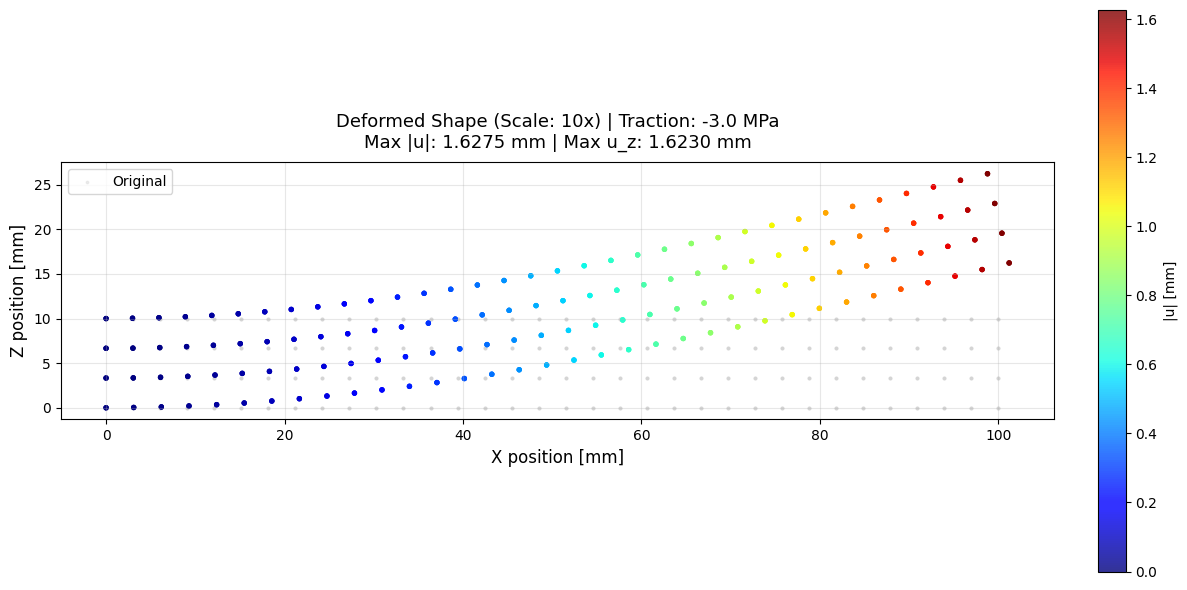

In [9]:
# Case 3: Negative traction (downward load)
plot_deformation(-3.0)

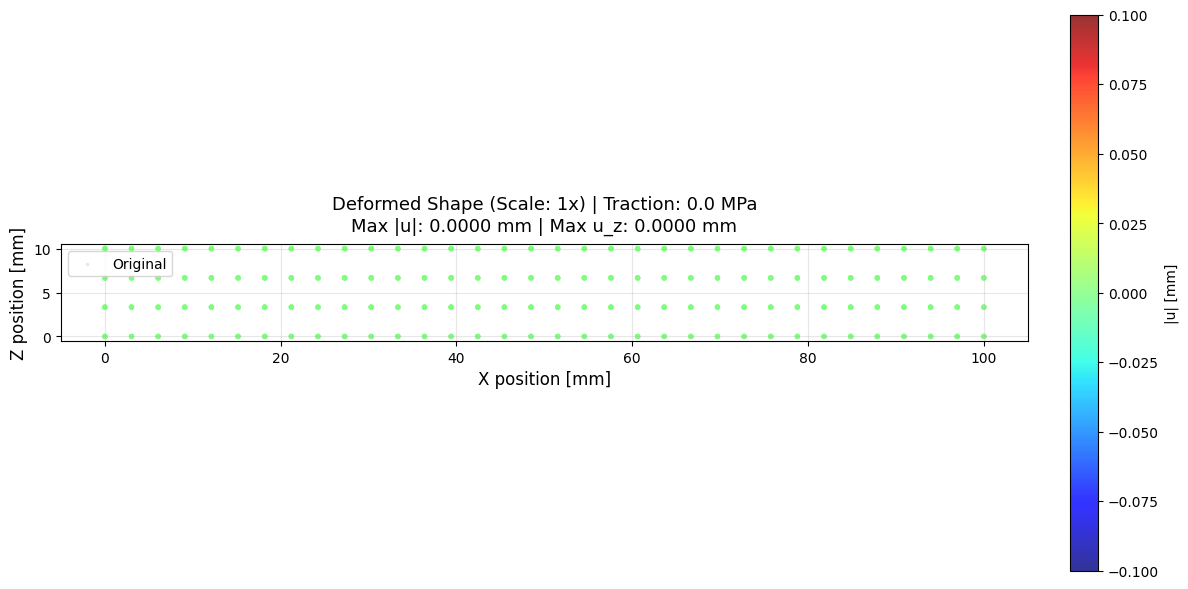

In [10]:
# Case 2: No load
plot_deformation(0.0)

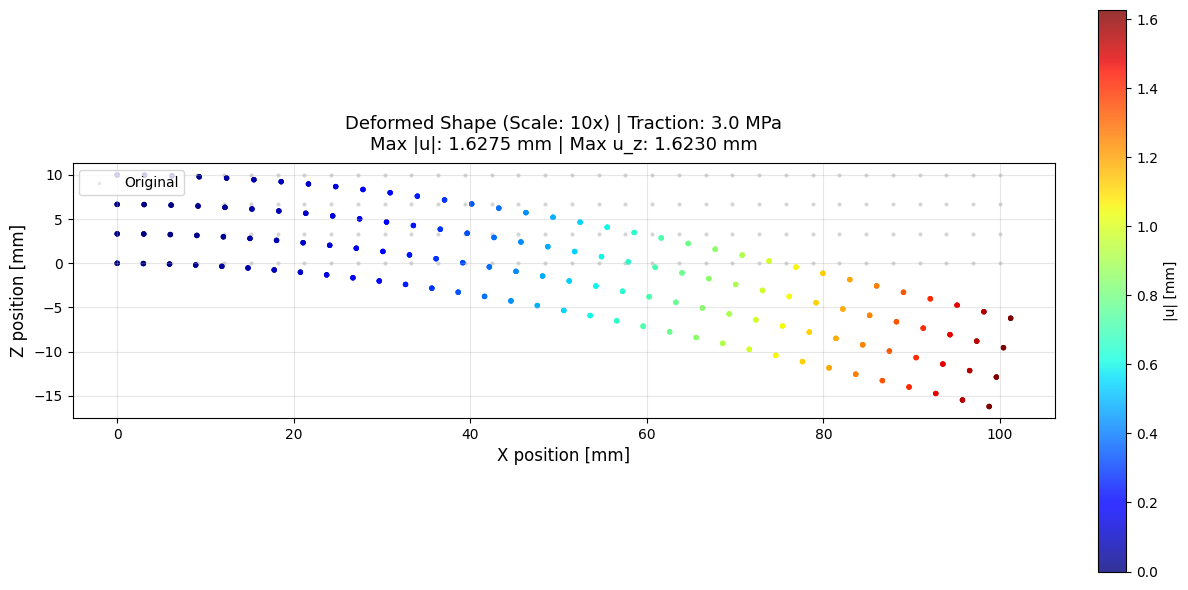

In [11]:
# Case 1: Positive traction (upward load)
plot_deformation(3.0)

## Quick Test: Individual Load Cases

Run each cell below to see different traction scenarios:

## Optional: Batch Analysis

Run multiple traction values at once to see the trend:

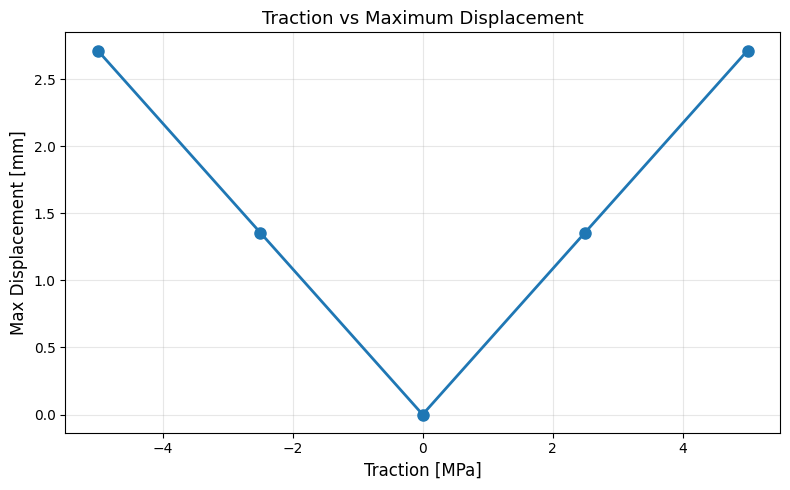

Linear relationship verified: 0.000000 correlation


In [12]:
# Analyze multiple traction values
traction_values = onp.linspace(-5, 5, 5)
max_displacements = []

for t in traction_values:
    traction_array = fe.internal_vars.InternalVars.create_uniform_surface_var(problem, t)
    sol = solve_forward(traction_array)
    sol_unflat = problem.unflatten_fn_sol_list(sol)
    displacement = onp.array(sol_unflat[0])
    u_mag = onp.sqrt(onp.sum(displacement**2, axis=1))
    max_displacements.append(onp.max(u_mag))

# Plot traction vs max displacement
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(traction_values, max_displacements, 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Traction [MPa]', fontsize=12)
ax.set_ylabel('Max Displacement [mm]', fontsize=12)
ax.set_title('Traction vs Maximum Displacement', fontsize=13)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Linear relationship verified: {onp.abs(onp.corrcoef(traction_values, max_displacements)[0,1]):.6f} correlation")